In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import pandas as pd

from arch import arch_model

plt.style.use('ggplot')

N = 3000
B = 500
#n = 1000
b = 50
N0 = 1500
B0 = 300
s0 = 0.1
s1 = 0.05
s2 = 0.04
#s0 = 0.02
#s1 = 0.02
#s2 = 0.02
µ = np.linspace(5, 10, 21)

# QUESTION 1 : 

In this first part, we're going to implement a random walk Metropolis
sampler that targets the posterior distribution of a GARCH model. First using generated data then using log-returns from real exchange rates data.  


Throughout the project we will be considering a GARCH(1,1) model as follows : 

$r_{t} = \epsilon_{t} \sqrt{h_{t}}$

with  $h_{t} = w_{0} + w_{1} r_{t-1}^2 + w_{2} h_{t-1}$

And $w_{0}>0, w_{1}>0, w_{2} >0$

As the paper suggests, we consider a Normal-GARCH model such that $r_{t}|F_{t-1}$, follows a normal distribution $\mathcal{N} (0,h_{t})$ and so $\epsilon_{t}$ follows a normal distribution $\mathcal{N} (0,1)$

## Using Generated Data

We start by generating our GARCH(1,1) data.

In [3]:
# GARCH(1, 1) parameters
w = np.array([1, 0.7, 0.2])
# number of iterations
n =1000


In [4]:
def garch(w, n):
    r = np.zeros(n)
    r[0] = np.random.randn()
    e = np.random.randn(n)
    h = np.zeros(n)
    h[0] = np.random.randn()
    for i in range(n-1):
        h[i+1] = w[0] + w[1] * r[i] * r[i] + w[2] * h[i]
        r[i+1] = e[i+1] * np.sqrt(h[i+1])
    return r

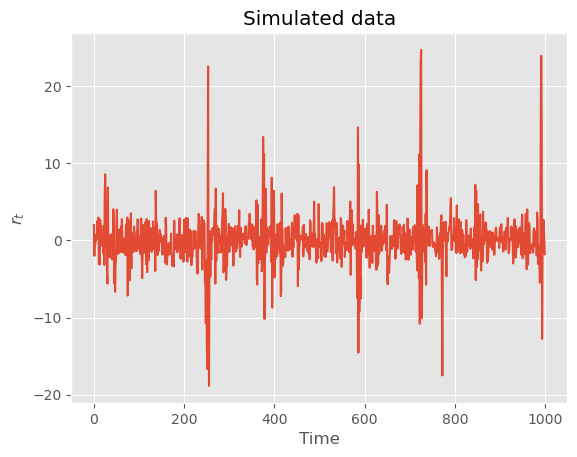

In [5]:
r = garch(w, n)

plt.plot(range(n), r)
plt.title('Simulated data')
plt.xlabel('Time')
plt.ylabel('$r_{t} $')
plt.show()

Now, we will be fitting a GARCH(1,1) model to our generated data, to check if our generation process is accurate.  

In [6]:
# by default the arch_model function assumes a GARCH(1,1) model
m = arch_model(r)
R = m.fit(update_freq=10)
print(R.summary())

Iteration:     10,   Func. Count:     60,   Neg. LLF: 2149.736064393662
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2149.510272507792
            Iterations: 15
            Function evaluations: 84
            Gradient evaluations: 15
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2149.51
Distribution:                  Normal   AIC:                           4307.02
Method:            Maximum Likelihood   BIC:                           4326.65
                                        No. Observations:                 1000
Date:                Sun, Apr 28 2024   Df Residuals:                      999
Time:                        12:41:24   Df Model:                            1
        

As we can see the fitting gives us approximately the exact parameters and distribution of the GARCH that we used for our data generation, which shows that our generation process is trustable.

### Metropolis for the generated data

We will be working in a Bayesian framework, our goal is to estimate the posterior distribution $ \pi(w|r) $ using a random walk Metropolis algorithm. $ \pi(w|r) $ represents the uncertainty about the parameters $ w $ given the observed data $ r $. 

Specifically, we are interested in estimating the expected value of $ \omega_j $ under the posterior distribution $ \pi(\omega_j|r) $. We assume that the prior distribution follows a normal distribution, but since the parameters $ w_j $ are constrained to be greater than 0, we need to consider truncated normal priors.

$ \pi(\omega_j | r) \propto f(r | \omega_j) \times \pi(\omega_j) $

Where:
- $ f(r | \omega_j) $ is the likelihood function, representing the probability of observing the data $ r $ given the parameters $ \omega_j $.
- $ \pi(\omega_j) $ is the prior distribution.

Note that :  

$\frac{\pi(W|r)}{\pi(w|r)} $ = $\exp \left( -\frac{1}{2} \left[ \sum_{t=1}^{T} \left( \ln \left( \frac{H_t}{h_t} \right) + r_t^2 \left( \frac{1}{H_t} - \frac{1}{h_t} \right) \right) + W^2 - w^2 \right] \right)$



In [7]:
# Extracting the conditional volatility from a garch model r
def sigmas(w, r):
    T = len(r)
    h = np.zeros(T)
    h[0] = np.random.random()
    for t in range(1, T):
        h[t] = w[0] + w[1] * r[t-1] * r[t-1] + w[2] * h[t-1]
    return h

# Acceptance probability for parameter w_j with a burn-in period b
def proba(w, W, r, b, j):
    T = len(r)
    h = sigmas(w, r)
    H = sigmas(W, r)
    S = 0
    S = sum(r[t] * r[t] * (1/H[t] - 1/h[t]) + np.log(H[t]) - np.log(h[t]) for t in range(b, T))
    if - (W[j] ** 2 - w[j] ** 2) / 2 - S / 2 > 1:
        return 1
    return np.exp(- (W[j] ** 2 - w[j] ** 2) / 2 - S / 2)

We use the following proposal distribution for our algorithm:

$ q(W|w)$ ~ $\mathcal{N} (w,s)$ 
where $s$ takes $s_{0}$, $s_{1}$ and $s_{2}$ respectively for the parameters $w_{0}$, $w_{1}$ and $w_{2}$

In addition the GARCH(1,1) model has a second-order and causal solution iff $ w_{1} +w_{2} < 1 $ 

In [8]:
def algo_RWMHwG(N, r, B, b):
    w = np.random.random(3) / 3
    W = np.copy(w)

    acceptance_counters = np.zeros(3) #counters for the acceptance rates

    # uniform variables for the acceptance step    
    u0 = np.random.random(N)
    u1 = np.random.random(N)
    u2 = np.random.random(N)

    # noise to sample according to the proposal distribution q
    v0 = np.random.randn(N) * s0
    v1 = np.random.randn(N) * s1
    v2 = np.random.randn(N) * s2
    
    #to store the values of the parameters
    w0 = np.zeros(N+1)
    w1 = np.zeros(N+1)
    w2 = np.zeros(N+1)

    #initialisation
    w0[0] = w[0]
    w1[0] = w[1]
    w2[0] = w[2]
    
    for i in range(N):
        if i%1000 == 0:
            print(str(i) + ' loops completed')
        
        W[0] += v0[i]
        if W[0] > 0:
            R = proba(w, W, r, b, 0)
            if R > u0[i]:
                w[0] += v0[i]
                acceptance_counters[0] += 1
            else:
                W[0] -= v0[i]
        else:
            W[0] -= v0[i]
        w0[i+1] = w[0]

        W[1] += v1[i]
        if W[1] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 1)
            if R > u1[i]:
                w[1] += v1[i]
                acceptance_counters[1] += 1
            else:
                W[1] -= v1[i]
        else:
            W[1] -= v1[i]
        w1[i+1] = w[1]

        W[2] += v2[i]
        if W[2] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 2)
            if R > u2[i]:
                w[2] += v2[i]
                acceptance_counters[2] += 1
            else:
                W[2] -= v2[i]
        else:
            W[2] -= v2[i]
        w2[i+1] = w[2]

    acceptance_rates = acceptance_counters / N
    
    # Mean
    RA0 = np.sum(w0[B:]) / (N - B + 1)
    RA1 = np.sum(w1[B:]) / (N - B + 1)
    RA2 = np.sum(w2[B:]) / (N - B + 1)

    # Variance
    RV0 = np.sum(w0[B:] ** 2) / (N - B + 1) - RA0 ** 2
    RV1 = np.sum(w1[B:] ** 2) / (N - B + 1) - RA1 ** 2
    RV2 = np.sum(w2[B:] ** 2) / (N - B + 1) - RA2 ** 2

    return [RA0, RA1, RA2], [RV0, RV1, RV2], acceptance_rates, w0, w1, w2

In [9]:
''''def algo_RWMHwG(N, r, B, b):
    w = np.random.random(3) / 3
    
    acceptance_counters = np.zeros(3) #counters for the acceptance rates
    uniform_vars = np.random.random((3, N)) # uniform variables for the acceptance step

    #to store the values of the parameters
    w0 = np.zeros(N+1)
    w1 = np.zeros(N+1)
    w2 = np.zeros(N+1)

    #initialisation
    w0[0] = w[0]
    w1[0] = w[1]
    w2[0] = w[2]
    
    for i in range(N):
        if i%1000 == 0:
            print(str(i) + ' loops completed')
        
        #W = np.array([np.random.normal(w[0], s0), np.random.normal(w[1], s1), np.random.normal(w[2], s2)])
        W = w + np.random.normal(0, [s0, s1, s2], size=3)

        if W[0] > 0 and W[1] > 0 and W[2] > 0 and W[1] + W[2] < 1:
            
            R = proba(w, W, r, b, 0)
            if R > uniform_vars[0,i]:
                w[0] = W[0] #we accept the candidate
                acceptance_counters[0] += 1

            R = proba(w, W, r, b, 1)
            if R > uniform_vars[1,i]:
                w[1] = W[1] 
                acceptance_counters[1] += 1
            
            R = proba(w, W, r, b, 2)
            if R > uniform_vars[2,i]:
                w[2] = W[2]
                acceptance_counters[2] += 1

        # we stock the values of the parameters
        w0[i+1] = w[0]    
        w1[i+1] = w[1]
        w2[i+1] = w[2]

    acceptance_rates = acceptance_counters / N
    
    # Mean
    RA0 = np.sum(w0[B:]) / (N - B + 1)
    RA1 = np.sum(w1[B:]) / (N - B + 1)
    RA2 = np.sum(w2[B:]) / (N - B + 1)

    # Variance
    RV0 = np.sum(w0[B:] ** 2) / (N - B + 1) - RA0 ** 2
    RV1 = np.sum(w1[B:] ** 2) / (N - B + 1) - RA1 ** 2
    RV2 = np.sum(w2[B:] ** 2) / (N - B + 1) - RA2 ** 2

    return [RA0, RA1, RA2] , [RV0, RV1, RV2], acceptance_rates, w0, w1, w2'''

"'def algo_RWMHwG(N, r, B, b):\n    w = np.random.random(3) / 3\n    \n    acceptance_counters = np.zeros(3) #counters for the acceptance rates\n    uniform_vars = np.random.random((3, N)) # uniform variables for the acceptance step\n\n    #to store the values of the parameters\n    w0 = np.zeros(N+1)\n    w1 = np.zeros(N+1)\n    w2 = np.zeros(N+1)\n\n    #initialisation\n    w0[0] = w[0]\n    w1[0] = w[1]\n    w2[0] = w[2]\n    \n    for i in range(N):\n        if i%1000 == 0:\n            print(str(i) + ' loops completed')\n        \n        #W = np.array([np.random.normal(w[0], s0), np.random.normal(w[1], s1), np.random.normal(w[2], s2)])\n        W = w + np.random.normal(0, [s0, s1, s2], size=3)\n\n        if W[0] > 0 and W[1] > 0 and W[2] > 0 and W[1] + W[2] < 1:\n            \n            R = proba(w, W, r, b, 0)\n            if R > uniform_vars[0,i]:\n                w[0] = W[0] #we accept the candidate\n                acceptance_counters[0] += 1\n\n            R = proba(w, W, 

In [10]:
U = algo_RWMHwG(N, r, B, b)

0 loops completed
1000 loops completed
2000 loops completed


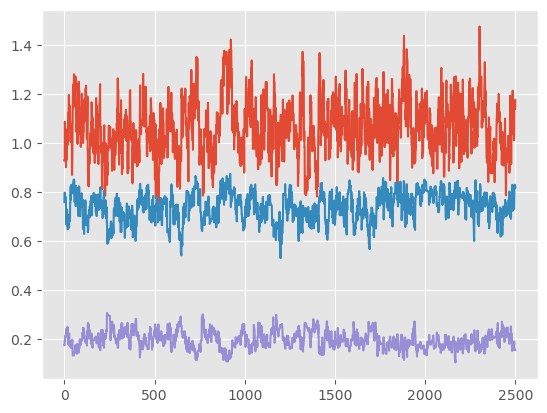

In [11]:
plt.plot(range(N-B+1), U[-3][B:])
plt.plot(range(N-B+1), U[-2][B:])
plt.plot(range(N-B+1), U[-1][B:])

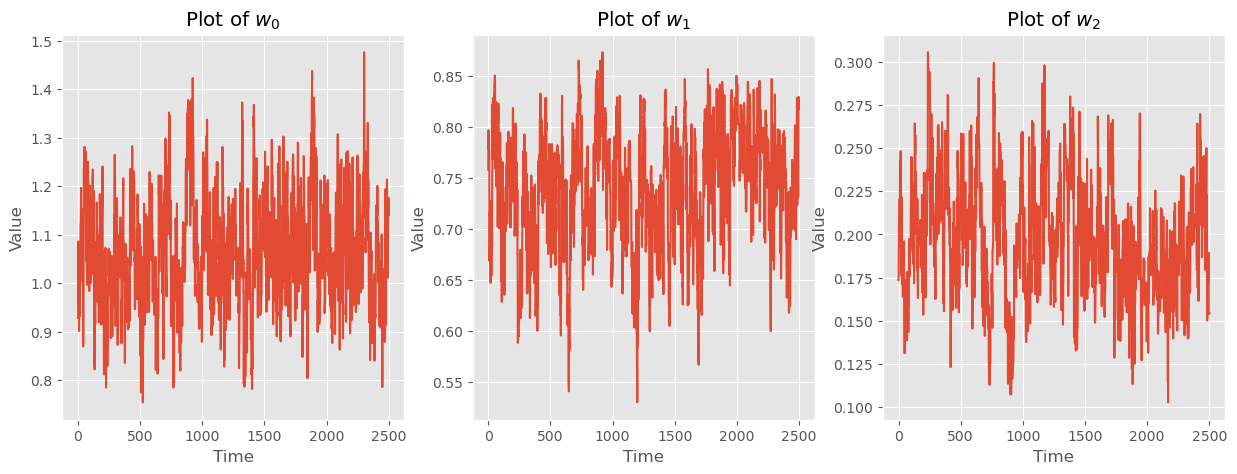

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(range(N-B+1), U[-3][B:])
axs[0].set_title('Plot of $w_{0}$')

axs[1].plot(range(N-B+1), U[-2][B:])
axs[1].set_title('Plot of $w_{1}$')

axs[2].plot(range(N-B+1), U[-1][B:])
axs[2].set_title('Plot of $w_{2}$')

for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

plt.show()

In [13]:
print(f"for w0  The acceptance rate is :{U[2][0]}  The mean is : {U[0][0]} The variance is : {U[1][0]}" )
print(f"for w1  The acceptance rate is :{U[2][1]}  The mean is : {U[0][1]} The variance is : {U[1][1]}" )
print(f"for w2  The acceptance rate is :{U[2][2]}  The mean is : {U[0][2]} The variance is : {U[1][2]}" )

for w0  The acceptance rate is :0.6736666666666666  The mean is : 1.0626207661437637 The variance is : 0.01334716064353847
for w1  The acceptance rate is :0.62  The mean is : 0.7395650856561187 The variance is : 0.0034834134132583072
for w2  The acceptance rate is :0.5006666666666667  The mean is : 0.19623968402277484 The variance is : 0.0012524637936771402


Let's plot the autocorrelations of our estimators 

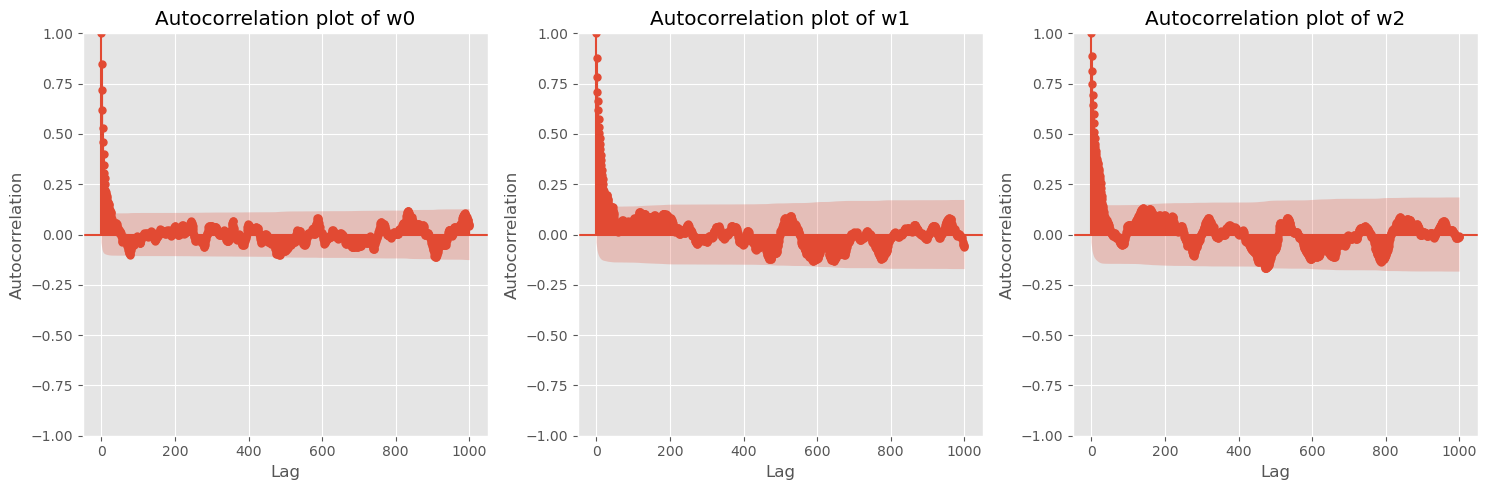

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Autocorrelation function plot for parameters w0, w1 and w2 
plot_acf(U[-3][B:], ax=axs[0], lags=1000)
axs[0].set_title("Autocorrelation plot of w0")
plot_acf(U[-2][B:], ax=axs[1], lags=1000)
axs[1].set_title("Autocorrelation plot of w1")
plot_acf(U[-1][B:], ax=axs[2], lags=1000)
axs[2].set_title("Autocorrelation plot of w2")

for ax in axs:
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True)

# display
plt.tight_layout()
plt.show()

### Metropolis for real data

Now we will be working with log-return computed from real exchange rates data. We have chosen to use EUR/USD exchange rates from January 1, 2004, to April 1, 2024, which we obtained from Yahoo Finance.

In [16]:
data = pd.read_csv("EURUSD.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-01-01,1.259002,1.260796,1.247396,1.258194,1.258194,0.0
1,2004-01-02,1.258194,1.262802,1.252693,1.258194,1.258194,0.0
2,2004-01-05,1.263903,1.269406,1.263695,1.268698,1.268698,0.0
3,2004-01-06,1.268907,1.280803,1.267202,1.272103,1.272103,0.0
4,2004-01-07,1.272394,1.273999,1.262499,1.264095,1.264095,0.0


In [17]:
# Calculate log-returns
data['Log_Return'] = np.log(data['Close']).diff()

# Drop NaN values resulting from the differencing operation
data.dropna(inplace=True)

# Print first few rows of the dataset with log-returns
print(data.head())

         Date      Open      High       Low     Close  Adj Close  Volume  \
1  2004-01-02  1.258194  1.262802  1.252693  1.258194   1.258194     0.0   
2  2004-01-05  1.263903  1.269406  1.263695  1.268698   1.268698     0.0   
3  2004-01-06  1.268907  1.280803  1.267202  1.272103   1.272103     0.0   
4  2004-01-07  1.272394  1.273999  1.262499  1.264095   1.264095     0.0   
5  2004-01-08  1.264095  1.278707  1.256502  1.277498   1.277498     0.0   

   Log_Return  
1    0.000000  
2    0.008314  
3    0.002680  
4   -0.006315  
5    0.010547  


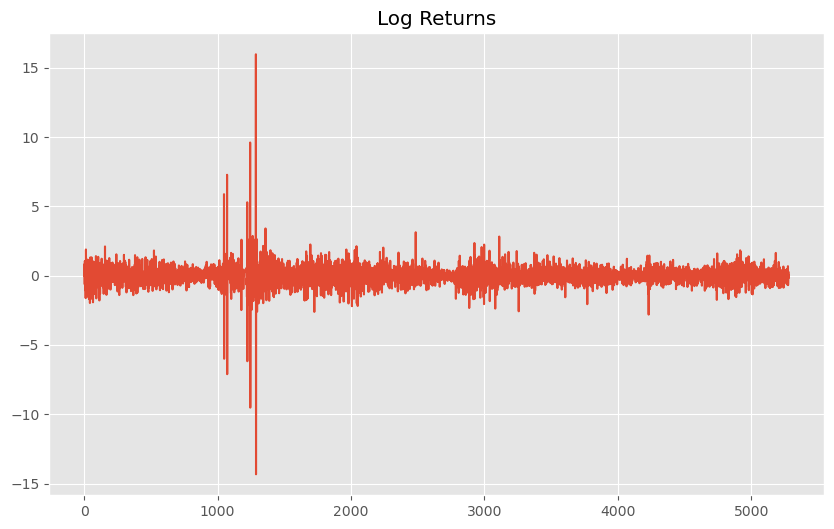

In [18]:
data['Log_Return'] = data['Log_Return'] * 100 # multiply by 100 to get in percentage because the values are close to 0

# Plot log returns
plt.figure(figsize=(10,6))
plt.plot(data['Log_Return'])
plt.title('Log Returns')
plt.show()

In [19]:
R = algo_RWMHwG(N, r, B, b)

0 loops completed
1000 loops completed
2000 loops completed


Let's look at the acceptation rates

In [20]:
print(R[2])

[0.68966667 0.62366667 0.48666667]


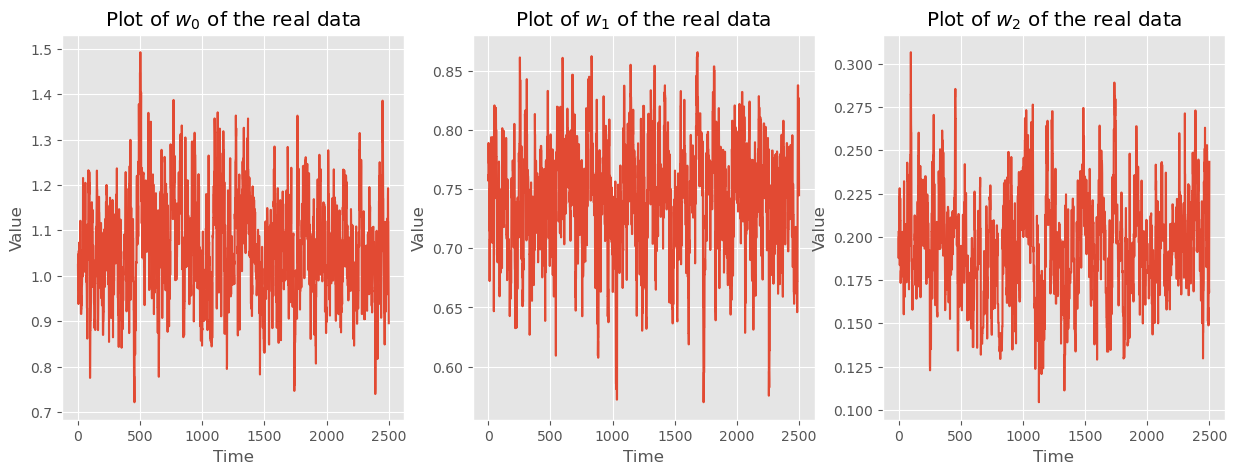

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(range(N-B+1), R[-3][B:])
axs[0].set_title('Plot of $w_{0}$ of the real data')

axs[1].plot(range(N-B+1), R[-2][B:])
axs[1].set_title('Plot of $w_{1}$ of the real data')

axs[2].plot(range(N-B+1), R[-1][B:])
axs[2].set_title('Plot of $w_{2}$ of the real data')

for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

plt.show()

In [24]:
print(f"for w0  The acceptance rate is :{R[2][0]}  The mean is : {R[0][0]} The variance is : {R[1][0]}" )
print(f"for w1  The acceptance rate is :{R[2][1]}  The mean is : {R[0][1]} The variance is : {R[1][1]}" )
print(f"for w2  The acceptance rate is :{R[2][2]}  The mean is : {R[0][2]} The variance is : {R[1][2]}" )

for w0  The acceptance rate is :0.6896666666666667  The mean is : 1.0631896720605618 The variance is : 0.012137349326657887
for w1  The acceptance rate is :0.6236666666666667  The mean is : 0.743834418099262 The variance is : 0.002489198210486432
for w2  The acceptance rate is :0.4866666666666667  The mean is : 0.1946460216001958 The variance is : 0.0009093018669303135


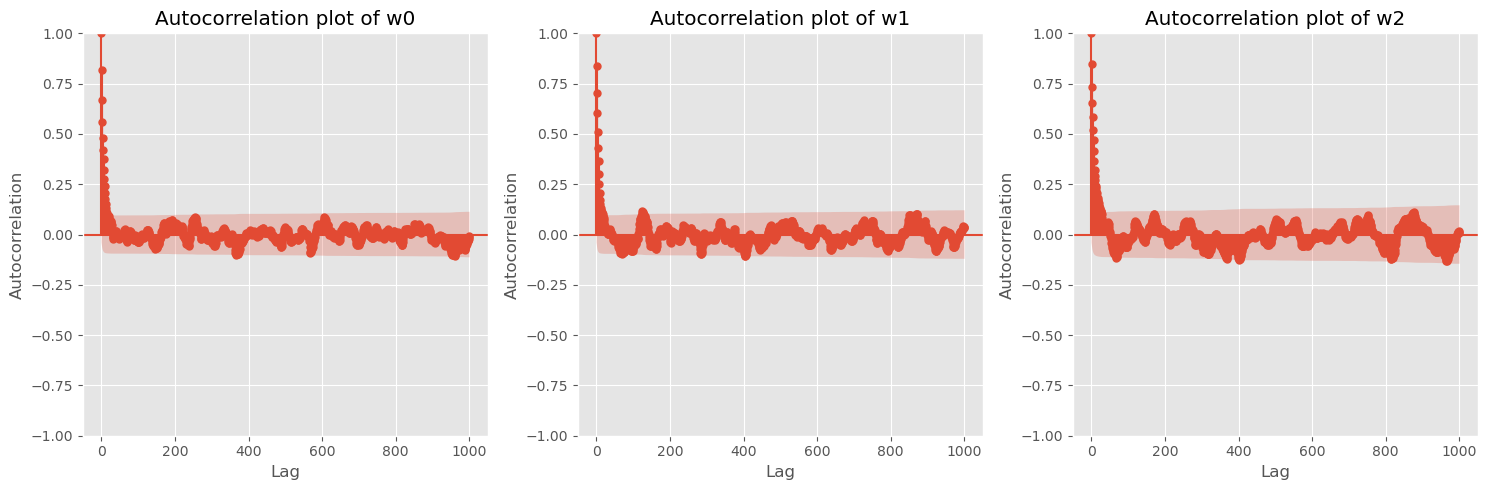

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Autocorrelation function plot for parameters w0, w1 and w2 
plot_acf(R[-3][B:], ax=axs[0], lags=1000)
axs[0].set_title("Autocorrelation plot of w0")
plot_acf(R[-2][B:], ax=axs[1], lags=1000)
axs[1].set_title("Autocorrelation plot of w1")
plot_acf(R[-1][B:], ax=axs[2], lags=1000)
axs[2].set_title("Autocorrelation plot of w2")

for ax in axs:
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True)

# display
plt.tight_layout()
plt.show()

QUESTION 2

In [14]:
def z_CV(w, r):
    T = len(r)
    h = sigmas(w, r)
    dh0 = np.zeros(T)
    dh1 = np.zeros(T)
    dh2 = np.zeros(T)
    for t in range(1, T):
        dh0[t] = 1 + w[2] * dh0[t-1]
        dh1[t] = r[t-1] * r[t-1] + w[2] * dh1[t-1]
        dh2[t] = h[t-1] + w[2] * dh1[t-1]
    S0 = 0
    S1 = 0
    S2 = 0
    for t in range(1, T):
        S0 += dh0[t] * (1 / h[t] - (r[t] / h[t]) ** 2)
        S1 += dh1[t] * (1 / h[t] - (r[t] / h[t]) ** 2)
        S2 += dh2[t] * (1 / h[t] - (r[t] / h[t]) ** 2)
    return np.array([(w[0] + S0 / 2) / 2, (w[1] + S1 / 2) / 2, (w[2] + S2 / 2) / 2])


def a_CV(r, s, N0, B0, b):
    U = algo_RWMHwG(N0, s, r, B0, b)
    w0 = np.copy(U[-3][B0:])
    w1 = np.copy(U[-2][B0:])
    w2 = np.copy(U[-1][B0:])
    Z = np.zeros((N0 - B0 + 1, 3))
    for i in range(N0 - B0 + 1):
        Z[i] = z_CV([w0[i], w1[i], w2[i]], r)
    Z = sm.add_constant(Z)
    M0 = sm.OLS(w0, Z)
    M1 = sm.OLS(w1, Z)
    M2 = sm.OLS(w2, Z)
    R0 = M0.fit()
    R1 = M1.fit()
    R2 = M2.fit()
    print(R0.summary())
    print(R1.summary())
    print(R2.summary())
    return - np.array(R0.params[1:]), - np.array(R1.params[1:]), - np.array(R2.params[1:])


def f_CV(w, r, a):
    z = z_CV(w, r)
    return w + np.dot(z, a)


def algo_RWMHwG_CV(N, s, r, B, b, N0, B0):
    a0, a1, a2 = a_CV(r, s, N0, B0, b)
    w = np.random.random(3) / 3
    W = np.copy(w)
    R = 0
    c0 = 0
    c1 = 0
    c2 = 0
    u0 = np.random.random(N)
    u1 = np.random.random(N)
    u2 = np.random.random(N)
    v0 = np.random.randn(N) * s0
    v1 = np.random.randn(N) * s1
    v2 = np.random.randn(N) * s2
    w0 = np.zeros(N+1)
    w1 = np.zeros(N+1)
    w2 = np.zeros(N+1)
    w0[0] = w[0]
    w1[0] = w[1]
    w2[0] = w[2]
    for i in range(N):
        if i%1000 == 0:
            print(str(i) + ' boucle(s) effectuée(s)')
        
        W[0] += v0[i]
        if W[0] > 0:
            R = proba(w, W, r, b, 0)
            if R > u0[i]:
                w[0] += v0[i]
                c0 += 1
            else:
                W[0] -= v0[i]
        else:
            W[0] -= v0[i]
        w0[i+1] = f_CV(w, r, a0)[0]

        W[1] += v1[i]
        if W[1] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 1)
            if R > u1[i]:
                w[1] += v1[i]
                c1 += 1
            else:
                W[1] -= v1[i]
        else:
            W[1] -= v1[i]
        w1[i+1] = f_CV(w, r, a1)[1]

        W[2] += v2[i]
        if W[2] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 2)
            if R > u2[i]:
                w[2] += v2[i]
                c2 += 1
            else:
                W[2] -= v2[i]
        else:
            W[2] -= v2[i]
        w2[i+1] = f_CV(w, r, a2)[2]

    c0 /= N
    c1 /= N
    c2 /= N
    RA0 = np.sum(w0[B:]) / (N - B + 1)
    RA1 = np.sum(w1[B:]) / (N - B + 1)
    RA2 = np.sum(w2[B:]) / (N - B + 1)
    RV0 = np.sum(w0[B:] ** 2) / (N - B + 1) - RA0 ** 2
    RV1 = np.sum(w1[B:] ** 2) / (N - B + 1) - RA1 ** 2
    RV2 = np.sum(w2[B:] ** 2) / (N - B + 1) - RA2 ** 2

    return RA0, RA1, RA2, RV0, RV1, RV2, c0, c1, c2, w0, w1, w2

In [42]:
V = algo_RWMHwG_CV(N, s, r, B, b, N0, B0)
print(V[:9])
plt.plot(range(N-99), V[-3][100:])
plt.plot(range(N-99), V[-2][100:])
plt.plot(range(N-99), V[-1][100:])

NameError: name 'algo_RWMHwG_CV' is not defined

QUESTION 3

In [61]:
def Support(T):
    t = 0
    for k in range(len(T)):
        if T[k] != 0:
            t += 1
    return t


def z_CVL(w, r):
    T = len(r)
    h = sigmas(w, r)
    dh0 = np.zeros(T)
    dh1 = np.zeros(T)
    dh2 = np.zeros(T)
    for t in range(1, T):
        dh0[t] = 1 + w[2] * dh0[t-1]
        dh1[t] = r[t-1] * r[t-1] + w[2] * dh1[t-1]
        dh2[t] = h[t-1] + w[2] * dh1[t-1]
    S0 = 0
    S1 = 0
    S2 = 0
    for t in range(1, T):
        S0 += dh0[t] * (1 / h[t] - (r[t] / h[t]) ** 2)
        S1 += dh1[t] * (1 / h[t] - (r[t] / h[t]) ** 2)
        S2 += dh2[t] * (1 / h[t] - (r[t] / h[t]) ** 2)
    z0 = (w[0] + S0 / 2) / 2
    z1 = (w[1] + S1 / 2) / 2
    z2 = (w[2] + S2 / 2) / 2
    return np.array([z0, z1, z2, w[0] * z0, w[1] * z1, w[2] * z2, w[0] * z1, w[1] * z2, w[2] * z0, w[0] * z2, w[1] * z0, w[2] * z1])


def a_dicho_CVL(r, s, N0, B0, b):
    U = algo_RWMHwG(N0, s, r, B0, b)
    z = 12
    w0 = np.copy(U[-3][B0:])
    w1 = np.copy(U[-2][B0:])
    w2 = np.copy(U[-1][B0:])
    Z = np.zeros((N0 - B0 + 1, z))
    for i in range(N0 - B0 + 1):
        Z[i] = z_CVL([w0[i], w1[i], w2[i]], r)
    Z = sm.add_constant(Z)
    M0 = sm.OLS(w0, Z)
    M1 = sm.OLS(w1, Z)
    M2 = sm.OLS(w2, Z)
    µ = 7
    R0 = M0.fit_regularized(alpha=µ, L1_wt=1.0)
    R1 = M1.fit_regularized(alpha=µ, L1_wt=1.0)
    R2 = M2.fit_regularized(alpha=µ, L1_wt=1.0)
    n0 = Support(R0.params[1:])
    n1 = Support(R1.params[1:])
    n2 = Support(R2.params[1:])
    x = 0.8
    c = 0
    while n0 != 3:
        if n0 > 3:
            µ += x
        else:
            if µ - x > 0:
                µ -= x
            else:
                µ *= 0.5
        c += 1
        if c > 5:
            x *= 0.5
            c = 0
        M0 = sm.OLS(w0, Z)
        R0 = M0.fit_regularized(alpha=µ, L1_wt=1.0)
        n0 = Support(R0.params[1:])
    print("Selection des variables de controle pour w0 complétée")
    µ = 7
    x = 0.8
    c = 0
    while n1 != 3:
        if n1 > 3:
            µ += x
        else:
            if µ - x > 0:
                µ -= x
            else:
                µ *= 0.5
        c += 1
        if c > 5:
            x *= 0.5
            c = 0
        M1 = sm.OLS(w1, Z)
        R1 = M1.fit_regularized(alpha=µ, L1_wt=1.0)
        n1 = Support(R1.params[1:])
    print("Selection des variables de controle pour w1 complétée")
    µ = 7
    x = 0.8
    c = 0
    while n2 != 3:
        if n2 > 3:
            µ += x
        else:
            if µ - x > 0:
                µ -= x
            else:
                µ *= 0.5
        c += 1
        if c > 5:
            x *= 0.5
            c = 0
        M2 = sm.OLS(w2, Z)
        R2 = M2.fit_regularized(alpha=µ, L1_wt=1.0)
        n2 = Support(R2.params[1:])
    print("Selection des variables de controle pour w2 complétée")
    y0 = []
    y1 = []
    y2 = []
    for i in range(1, z + 1):
        if R0.params[i] != 0:
            y0.append(i-1)
        if R1.params[i] != 0:
            y1.append(i-1)
        if R2.params[i] != 0:
            y2.append(i-1)
    X0 = np.zeros((N0 - B0 + 1, 3))    
    X0[:, 0] = np.copy(Z[:, y0[0] + 1])
    X0[:, 1] = np.copy(Z[:, y0[1] + 1])
    X0[:, 2] = np.copy(Z[:, y0[2] + 1])
    X0 = sm.add_constant(X0)
    X1 = np.zeros((N0 - B0 + 1, 3))
    X1[:, 0] = np.copy(Z[:, y1[0] + 1])
    X1[:, 1] = np.copy(Z[:, y1[1] + 1])
    X1[:, 2] = np.copy(Z[:, y1[2] + 1])
    X1 = sm.add_constant(X1)
    X2 = np.zeros((N0 - B0 + 1, 3))
    X2[:, 0] = np.copy(Z[:, y2[0] + 1])
    X2[:, 1] = np.copy(Z[:, y2[1] + 1])
    X2[:, 2] = np.copy(Z[:, y2[2] + 1])
    X2 = sm.add_constant(X2)
    P0 = sm.OLS(w0, X0)
    P1 = sm.OLS(w1, X1)
    P2 = sm.OLS(w2, X2)
    Q0 = P0.fit()
    Q1 = P1.fit()
    Q2 = P2.fit()
    print(Q0.summary())
    print(Q1.summary())
    print(Q2.summary())
    print(y0, y1, y2)
    return y0, - np.array(Q0.params[1:]), y1, - np.array(Q1.params[1:]), y2, - np.array(Q2.params[1:])


def f_CVL(w, r, a, y):
    z = z_CVL(w, r)
    t = []
    for x in y:
        t.append(z[x])
    return w + np.dot(t, a)


def algo_RWMHwG_dicho_CVL(N, s, r, B, b, N0, B0):
    A = a_dicho_CVL(r, s, N0, B0, b)
    y0, a0, y1, a1, y2, a2 = A[0], A[1], A[2], A[3], A[4], A[5]
    w = np.random.random(3) / 3
    W = np.copy(w)
    R = 0
    c0 = 0
    c1 = 0
    c2 = 0
    u0 = np.random.random(N)
    u1 = np.random.random(N)
    u2 = np.random.random(N)
    v0 = np.random.randn(N) * s0
    v1 = np.random.randn(N) * s1
    v2 = np.random.randn(N) * s2
    w0 = np.zeros(N+1)
    w1 = np.zeros(N+1)
    w2 = np.zeros(N+1)
    w0[0] = w[0]
    w1[0] = w[1]
    w2[0] = w[2]
    for i in range(N):
        if i%1000 == 0:
            print(str(i) + ' boucle(s) effectuée(s)')
        
        W[0] += v0[i]
        if W[0] > 0:
            R = proba(w, W, r, b, 0)
            if R > u0[i]:
                w[0] += v0[i]
                c0 += 1
            else:
                W[0] -= v0[i]
        else:
            W[0] -= v0[i]
        w0[i+1] = f_CVL(w, r, a0, y0)[0]

        W[1] += v1[i]
        if W[1] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 1)
            if R > u1[i]:
                w[1] += v1[i]
                c1 += 1
            else:
                W[1] -= v1[i]
        else:
            W[1] -= v1[i]
        w1[i+1] = f_CVL(w, r, a1, y1)[1]

        W[2] += v2[i]
        if W[2] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 2)
            if R > u2[i]:
                w[2] += v2[i]
                c2 += 1
            else:
                W[2] -= v2[i]
        else:
            W[2] -= v2[i]
        w2[i+1] = f_CVL(w, r, a2, y2)[2]

    c0 /= N
    c1 /= N
    c2 /= N
    RA0 = np.sum(w0[B:]) / (N - B + 1)
    RA1 = np.sum(w1[B:]) / (N - B + 1)
    RA2 = np.sum(w2[B:]) / (N - B + 1)
    RV0 = np.sum(w0[B:] ** 2) / (N - B + 1) - RA0 ** 2
    RV1 = np.sum(w1[B:] ** 2) / (N - B + 1) - RA1 ** 2
    RV2 = np.sum(w2[B:] ** 2) / (N - B + 1) - RA2 ** 2

    return RA0, RA1, RA2, RV0, RV1, RV2, c0, c1, c2, w0, w1, w2

0 boucle(s) effectuée(s)
1000 boucle(s) effectuée(s)
Selection des variables de controle pour w0 complétée
Selection des variables de controle pour w1 complétée
Selection des variables de controle pour w2 complétée
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     64.12
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           1.89e-38
Time:                        12:35:59   Log-Likelihood:                 910.90
No. Observations:                1201   AIC:                            -1814.
Df Residuals:                    1197   BIC:                            -1793.
Df Model:                           3                                         
Covariance Type:            nonrobust                                     

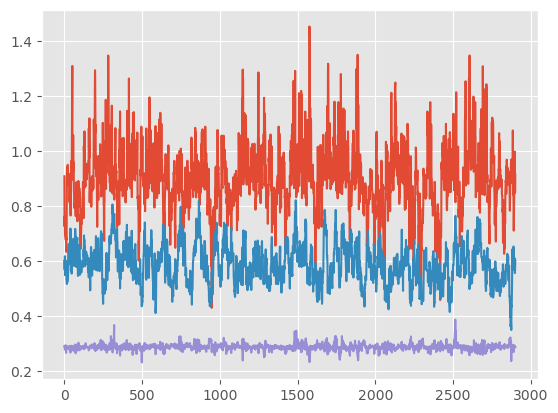

In [62]:
W = algo_RWMHwG_dicho_CVL(N, s, r, B, b, N0, B0)
print(W[:9])
plt.plot(range(N-99), W[-3][100:])
plt.plot(range(N-99), W[-2][100:])
plt.plot(range(N-99), W[-1][100:])

In [59]:
def a_Kfold_CVL(r, s, N0, B0, b):
    U = algo_RWMHwG(N0, s, r, B0, b)
    z = 12
    m = z // 3
    w0 = np.copy(U[-3][B0:])
    w1 = np.copy(U[-2][B0:])
    w2 = np.copy(U[-1][B0:])
    Z = np.zeros((N0 - B0 + 1, z))
    for k in range(N0 - B0 + 1):
        Z[k] = z_CVL([w0[k], w1[k], w2[k]], r)
    x = np.zeros((m ** 3, 3), dtype=int)
    c = 0
    for i in range(m):
        for j in range(m):
            for k in range(m):
                x[c] = np.array([i * 3, 1 + j * 3, 2 + k * 3])
                x[c].sort()
                c += 1
    M0 = 0
    M1 = 0
    M2 = 0
    for p in range(m ** 3):
        X = np.zeros((N0 - B0 + 1, 3))
        X[:, 0] = np.copy(Z[:, x[p, 0]])
        X[:, 1] = np.copy(Z[:, x[p, 1]])
        X[:, 2] = np.copy(Z[:, x[p, 2]])
        X = sm.add_constant(X)
        Q0 = sm.OLS(w0, X)
        Q1 = sm.OLS(w1, X)
        Q2 = sm.OLS(w2, X)
        R0 = Q0.fit()
        R1 = Q1.fit()
        R2 = Q2.fit()
        r0 = R0.rsquared
        r1 = R1.rsquared
        r2 = R2.rsquared
        if r0 > M0:
            y0 = np.copy(x[p])
            a0 = - np.array(R0.params[1:])
            M0 = r0
        if r1 > M1:
            y1 = np.copy(x[p])
            a1 = - np.array(R1.params[1:])
            M1 = r1
        if r2 > M2:
            y2 = np.copy(x[p])
            a2 = - np.array(R2.params[1:])
            M2 = r2
    print(y0, y1, y2)
    print(M0, M1, M2)
    return y0, a0, y1, a1, y2, a2

        
def algo_RWMHwG_Kfold_CVL(N, s, r, B, b, N0, B0):
    A = a_Kfold_CVL(r, s, N0, B0, b)
    y0, a0, y1, a1, y2, a2 = A[0], A[1], A[2], A[3], A[4], A[5]
    w = np.random.random(3) / 3
    W = np.copy(w)
    R = 0
    c0 = 0
    c1 = 0
    c2 = 0
    u0 = np.random.random(N)
    u1 = np.random.random(N)
    u2 = np.random.random(N)
    v0 = np.random.randn(N) * s0
    v1 = np.random.randn(N) * s1
    v2 = np.random.randn(N) * s2
    w0 = np.zeros(N+1)
    w1 = np.zeros(N+1)
    w2 = np.zeros(N+1)
    w0[0] = w[0]
    w1[0] = w[1]
    w2[0] = w[2]
    for i in range(N):
        if i%1000 == 0:
            print(str(i) + ' boucle(s) effectuée(s)')
        
        W[0] += v0[i]
        if W[0] > 0:
            R = proba(w, W, r, b, 0)
            if R > u0[i]:
                w[0] += v0[i]
                c0 += 1
            else:
                W[0] -= v0[i]
        else:
            W[0] -= v0[i]
        w0[i+1] = f_CVL(w, r, a0, y0)[0]

        W[1] += v1[i]
        if W[1] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 1)
            if R > u1[i]:
                w[1] += v1[i]
                c1 += 1
            else:
                W[1] -= v1[i]
        else:
            W[1] -= v1[i]
        w1[i+1] = f_CVL(w, r, a1, y1)[1]

        W[2] += v2[i]
        if W[2] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 2)
            if R > u2[i]:
                w[2] += v2[i]
                c2 += 1
            else:
                W[2] -= v2[i]
        else:
            W[2] -= v2[i]
        w2[i+1] = f_CVL(w, r, a2, y2)[2]

    c0 /= N
    c1 /= N
    c2 /= N
    RA0 = np.sum(w0[B:]) / (N - B + 1)
    RA1 = np.sum(w1[B:]) / (N - B + 1)
    RA2 = np.sum(w2[B:]) / (N - B + 1)
    RV0 = np.sum(w0[B:] ** 2) / (N - B + 1) - RA0 ** 2
    RV1 = np.sum(w1[B:] ** 2) / (N - B + 1) - RA1 ** 2
    RV2 = np.sum(w2[B:] ** 2) / (N - B + 1) - RA2 ** 2

    return RA0, RA1, RA2, RV0, RV1, RV2, c0, c1, c2, w0, w1, w2

0 boucle(s) effectuée(s)
1000 boucle(s) effectuée(s)
[2 3 7] [2 4 9] [2 3 4]
0.9915573697970638 0.9900933990413288 0.9721730829446046
0 boucle(s) effectuée(s)
1000 boucle(s) effectuée(s)
2000 boucle(s) effectuée(s)
(0.9160404454865704, 0.5563277118767963, 0.2931246803621103, 0.00020503146138695083, 4.679310228800082e-05, 8.88117677744632e-05, 0.6366666666666667, 0.6846666666666666, 0.5543333333333333)


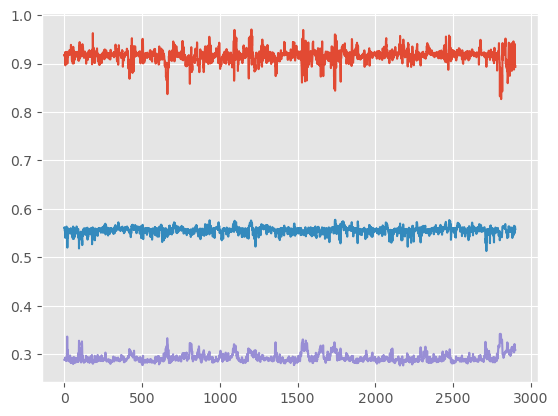

In [60]:
T = algo_RWMHwG_Kfold_CVL(N, s, r, B, b, N0, B0)
print(T[:9])
plt.plot(range(N-99), T[-3][100:])
plt.plot(range(N-99), T[-2][100:])
plt.plot(range(N-99), T[-1][100:])